In [1]:
import time

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.10Ef' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

from impyute.imputation import cs
pd.options.display.float_format = '{:20,.15f}'.format

from pprint import pprint

import copy
from sklearn.ensemble import ExtraTreesRegressor

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, he_normal, he_uniform
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import backend as K
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
# cols_to_exclude = ['genre__western', 'genre__documentary', 'genre__history', 'country__es', 'country__jp', 'country__ca', 'country__de', 'country__in', 'country__fr', 'country__ru', 'country__it', 'country__au', 'rating__nc-17', 'country__other', 'tag__satire', 'tag__neo_noir', 'tag__sadist', 'tag__cruelty', 'tag__dark', 'tag__storytelling', 'tag__sci_fi', 'tag__psychological', 'tag__absurd', 'tag__philosophical', 'tag__depressing', 'tag__plot_twist', 'tag__realism', 'tag__home_movie', 'tag__thought_provoking']
# cols_to_exclude = [col for col in df.columns if (('budget' in col or 'profit' in col) and ('crew' in col or 'cast' in col))]
cols_to_exclude = []

# def get_train_test_revenue(df):
#     df['revenue'] = df['META__revenue']
#     dff = df[[col for col in df.columns if not 'META' in col and not 'PROCESS' in col and not 'profitability' in col and col not in cols_to_exclude]]
#     X = dff.drop(['revenue'], axis=1)
#     y = dff['revenue']
#     return X, y


def get_train_test_revenue(df):
    df['revenue'] = df['META__revenue']
    dff = df[[col for col in df.columns if not 'META' in col]]
    X = dff.drop(['revenue'], axis=1)
    y = dff['revenue']
    return X, y

In [10]:
df_raw = pd.read_csv('savedcsv/dataset_all.csv')
# df_raw = reduce_mem_usage(df_raw)
df = shuffle(df_raw, random_state=0)

num_in_train = int(df.shape[0]*0.8)
# num_in_test = int(df.shape[0]*0.1)
num_in_test = int(df.shape[0]*0.1)
df_train = df[:num_in_train]
df_test = df[num_in_train:num_in_train+num_in_test]
df_val = df[num_in_train+num_in_test:]
X_train, y_train = get_train_test_revenue(df_train)
X_test, y_test = get_train_test_revenue(df_test)
X_val, y_val = get_train_test_revenue(df_val)

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(5994, 292)
(749, 292)
(750, 292)


In [13]:
list(X_train.columns)

['budget',
 'runtime',
 'spoken_languages',
 'weekend',
 'genre__war',
 'genre__western',
 'genre__mystery',
 'genre__music',
 'genre__crime',
 'genre__romance',
 'genre__action',
 'genre__adventure',
 'genre__thriller',
 'genre__animation',
 'genre__family',
 'genre__drama',
 'genre__comedy',
 'genre__documentary',
 'genre__history',
 'genre__fantasy',
 'genre__horror',
 'country__es',
 'country__jp',
 'country__us',
 'country__ca',
 'country__de',
 'country__cn',
 'country__in',
 'country__fr',
 'country__ru',
 'country__it',
 'country__au',
 'country__gb',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'competition',
 'rating__g',
 'rating__pg',
 'rating__pg-13',
 'rating__r',
 'rating__nc-17',
 'country__other',
 'tag__murder',
 'tag__violence',
 'tag__flashback',
 'tag__romantic',
 'tag__cult',
 'tag__revenge',
 'tag__psychedelic',
 'tag__comedy',
 'tag__suspenseful',
 'tag__good_versus_evil',
 'tag__humor',
 'tag__satire',
 'tag__entertaining',
 'tag__neo_noir',
 'tag__acti

In [14]:
class Process:
    def __init__(self, 
                 X_train, X_test, X_val, y_train, y_test, y_val, 
                 imputer='mean', 
                 minmaxrange=(-1,1), 
                 standardize_X=True,
                 standardize_y=True,
                 robust_range=(10, 90),
                ):
        self.y_process = []
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.X_val = X_val.copy()
        self.y_train = y_train.copy().values.reshape(-1, 1)
        self.y_test = y_test.copy().values.reshape(-1, 1)
        self.y_val = y_val.copy().values.reshape(-1, 1)
        self.imputer = imputer
        self.X_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.X_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.skewer_X = PowerTransformer(standardize=standardize_X)
        self.skewer_y = PowerTransformer(standardize=standardize_y)

    def fill_nan(self):
        def fill_train_test(imputer):
            imputer.fit(self.X_train)
            self.X_train[:] = imputer.transform(self.X_train)
            self.X_test[:] = imputer.transform(self.X_test)
            self.X_val[:] = imputer.transform(self.X_val)

        if (self.imputer == 'mean'):
            fill_train_test(SimpleImputer(strategy='mean'))
        elif (self.imputer == 'median'):
            fill_train_test(SimpleImputer(strategy='median'))
        elif (self.imputer == 'knn'):
            fill_train_test(KNNImputer())
        elif (self.imputer == 'iterative'):
            fill_train_test(IterativeImputer(verbose=0, max_iter=50))
        elif (self.imputer == 'iterative_mlp'):
            fill_train_test(
                IterativeImputer(
                    estimator=MLPRegressor(learning_rate='adaptive', random_state=0),
                    verbose=2,
                )
            )
        return self
        
    def minmaxscale_X(self):
        self.X_minmaxscaler.fit(self.X_train)
        self.X_train[:] = self.X_minmaxscaler.transform(self.X_train)
        self.X_test[:] = self.X_minmaxscaler.transform(self.X_test)
        self.X_val[:] = self.X_minmaxscaler.transform(self.X_val)
        return self
    
    def minmaxscale_X_inverse(self, data):
        return self.X_minmaxscaler.inverse_transform(data)
    
    def minmaxscale_Y(self, inverse=False):
        self.y_minmaxscaler.fit(self.y_train)
        self.y_train[:] = self.y_minmaxscaler.transform(self.y_train)
        self.y_test[:] = self.y_minmaxscaler.transform(self.y_test)
        self.y_val[:] = self.y_minmaxscaler.transform(self.y_val)
        self.y_process.append(self.minmaxscale_Y_inverse)
        return self
    
    def minmaxscale_Y_inverse(self, data): # data is in 1d array
        return self.y_minmaxscaler.inverse_transform(data.reshape(-1, 1)).flatten()
    
    def robustscale_X(self):
        self.X_robust_scaler.fit(self.X_train)
        self.X_train[:] = self.X_robust_scaler.transform(self.X_train)
        self.X_test[:] = self.X_robust_scaler.transform(self.X_test)
        self.X_val[:] = self.X_robust_scaler.transform(self.X_val)
        return self
    
    def robustscale_X_inverse(self, data):
        return self.X_robust_scaler.inverse_transform(data)
    
    def robustscale_Y(self, inverse=False):
        self.y_robust_scaler.fit(self.y_train)
        self.y_train[:] = self.y_robust_scaler.transform(self.y_train)
        self.y_test[:] = self.y_robust_scaler.transform(self.y_test)
        self.y_val[:] = self.y_robust_scaler.transform(self.y_val)
        self.y_process.append(self.robustscale_Y_inverse)
        return self
    
    def robustscale_Y_inverse(self, data): # data is in 1d array
        return self.y_robust_scaler.inverse_transform(data.reshape(-1, 1)).flatten()
    
    def skew_X(self, inverse=False):
        self.skewer_X.fit(self.X_train)
        self.X_train[:] = self.skewer_X.transform(self.X_train)
        self.X_test[:] = self.skewer_X.transform(self.X_test)
        self.X_val[:] = self.skewer_X.transform(self.X_val)
        return self
    
    def skew_X_inverse(self, data):
        return self.skewer_X.inverse_transform(data)
    
    def skew_y(self):
        self.skewer_y.fit(self.y_train)
        self.y_train = self.skewer_y.transform(self.y_train)
        self.y_test = self.skewer_y.transform(self.y_test)
        self.y_val = self.skewer_y.transform(self.y_val)
        self.y_process.append(self.skew_y_inverse)
        return self

    def skew_y_inverse(self, data): # data is 1d ndarray
        return self.skewer_y.inverse_transform(data.reshape(-1, 1)).flatten()

    def return_processed(self):
        return self.X_train, self.X_test, self.X_val, self.y_train.flatten(), self.y_test.flatten(), self.y_val.flatten()      

In [15]:
def get_metrics(y_test, y_pred, cols):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (float(SS_Residual))/SS_Total
    adj_r2 = 1 - (1-r2)*(len(y_test) - 1)/(len(y_test) - cols -1)
    return  {
        'mape': (abs((y_test - y_pred)/y_test)).mean(),
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'adj_r2': adj_r2,
    }

def print_metrics(data, y_test, y_pred, cols):
    print(data)
    res = get_metrics(y_test, y_pred, cols)
    for key in res:
        print(f'{key}: {res[key]}')
    return res


def predict(model, model_name, X_train, y_train, X_test, y_test):
    pred_train = model.predict(X_train.values)
    pred_test = model.predict(X_test.values)
    if len(pred_train.shape) == 2 and pred_train.shape[1] == 1:
        pred_train = pred_train.flatten()
        pred_test = pred_test.flatten()
    return {
        'res': {
            'train': print_metrics('train', y_train, pred_train, X_train.shape[1]),
            'test': print_metrics('test', y_test, pred_test, X_test.shape[1]),
        },
        'predictions':{
            'train': pred_train,
            'test': pred_test,
        },
        'actual': {
            'train': y_train,
            'test': y_test,
        },
    }


def output_metrics(model, data, process, with_val=True):
    if with_val:  
        res = predict(model, "Keras NN", 
                       data['X_train'],  
                       data['y_train'],
                       data['X_val'],
                       data['y_val'])
    else:
        res = predict(model, "Keras NN", 
                       data['X_train'],  
                       data['y_train'],  
                       data['X_test'],
                       data['y_test'])

    y_actual_train_back = res['actual']['train']
    y_pred_train_back = res['predictions']['train']
    y_actual_test_back = res['actual']['test']
    y_pred_test_back = res['predictions']['test']
    
    print_sorted_actual_to_predicted_graphs(
        y_actual_train_back,
        y_pred_train_back,
        y_actual_test_back,
        y_pred_test_back)

    if process and process.y_process:
        for apply_function in reversed(process.y_process):
            y_actual_train_back = apply_function(y_actual_train_back)
            y_pred_train_back = apply_function(y_pred_train_back)
            y_actual_test_back = apply_function(y_actual_test_back)
            y_pred_test_back = apply_function(y_pred_test_back)

        print_metrics('train', y_actual_train_back, y_pred_train_back, data['X_train'].shape[1])
        print_metrics('test', y_actual_test_back, y_pred_test_back, data['X_test'].shape[1])
        print_sorted_actual_to_predicted_graphs(
            y_actual_train_back,
            y_pred_train_back,
            y_actual_test_back,
            y_pred_test_back, print_log=True)


def print_graphs(actual, predicted, print_log=False):
    length = len(actual)
    res_df = pd.DataFrame({'actual':actual, 'predicted': predicted}).astype(float)
    res_df.sort_values(by='actual', inplace=True)

    plt.figure()
    x = np.linspace(0, length, length)
    plt.plot(x, res_df['actual'], label='actual')
    plt.plot(x, res_df['predicted'], label='predicted')

    plt.ticklabel_format(useOffset=False, style='plain')
    plt.rcParams["figure.figsize"] = (8,8)
    if print_log:
        plt.yscale('log')
    plt.show()
    
def print_sorted_actual_to_predicted_graphs(train_real, train_pred, test_real, test_pred, print_log=False):
    if print_log:
        print('train log')
        print_graphs(train_real, train_pred, print_log=True)
        print('test log')
        print_graphs(test_real, test_pred, print_log=True)
    print('train')
    print_graphs(train_real, train_pred)
    print('test')
    print_graphs(test_real, test_pred)
    
# -----------------------------------------

def get_data():
    with open('proc_data_001.pickle', 'rb') as handle:
        d = pickle.load(handle)
        X_train = d['X_train']
        y_train = d['y_train']
        X_test = d['X_test']
        y_test = d['y_test']
        return X_train, y_train, X_test, y_test

In [16]:
def get_process_and_data():
    data = {}
    process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().robustscale_Y().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().robustscale_X().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').robustscale_X().robustscale_Y().skew_X().skew_y().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().robustscale_X().robustscale_Y().fill_nan()
    data['X_train'], data['X_test'], data['X_val'], data['y_train'], data['y_test'], data['y_val'] = process.return_processed()
    return data, process

In [17]:
data, process = get_process_and_data()

In [18]:
import pickle
with open('dataset_all.pickle', 'wb') as handle:
    pickle.dump(data, handle)
    
with open('dataset_all.pickle', 'wb') as handle:
    pickle.dump(process, handle)
    
# with open('proc_data_001.pickle', 'rb') as handle:
#     d2 = pickle.load(handle)
    
# with open('proc_process_001.pickle', 'rb') as handle:
#     p2 = pickle.load(handle)

In [ ]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":25, 
            "eval_metric" : 'mse', 
            "eval_set" : [(data['X_test'], data['y_test'])],
#             'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
}

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={
    'num_leaves': sp_randint(5, 500), 
    'max_depth': sp_randint(5, 100),
    'max_bin': sp_randint(100, 1000),
    'min_child_samples': sp_randint(100, 400), 
#     'learning_rate': [0.01, 0.001, 0.0001],
#     'n_estimators': [2500, 5000, 7500, 10000],
#     'min_child_weight': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],
#     'min_child_samples': sp_randint(100, 400), 
#     'subsample': sp_uniform(loc=0.3, scale=0.5), 
#     'colsample_bytree': sp_uniform(loc=0.6, scale=0.3),
#     'reg_alpha': sp_uniform(loc=0, scale=5),
#     'reg_lambda': sp_randint(1, 50),
#     'max_bin': sp_randint(100, 500),
#     'bagging_fraction': sp_uniform(loc=0.7, scale=0.3),
#     'bagging_freq': sp_randint(5, 20),
#     'feature_fraction': sp_uniform(loc=0.5, scale=0.5),
#     'min_data_in_leaf': sp_randint(1, 500),
#     'min_sum_hessian_in_leaf': [1, 5, 10, 25, 50, 100],
}

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf = lgb.LGBMRegressor(
    num_threads=12,
    max_depth=-1, 
    random_state=314, 
    silent=True, 
    n_jobs=-1,
    verbose=4,
    tree_learner='data',
    learning_rate=0.001,
    num_iterations=100000,
    min_child_weight=10,
    subsample=0.4,
    colsample_bytree=0.73,
    reg_alpha=3.15,
    reg_lambda=26,
    bagging_fraction=0.96,
    bagging_freq=6,
    feature_fraction=0.6,
    min_data_in_leaf=50,
    min_sum_hessian_in_leaf=50,
)
gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=5,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
gs.fit(
    data['X_train'], 
    data['y_train'], 
    **fit_params,
)

In [ ]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

/home/stas/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.967429	valid_0's l2: 0.935918
[4]	valid_0's rmse: 0.966359	valid_0's l2: 0.93385
[6]	valid_0's rmse: 0.965432	valid_0's l2: 0.932058
[8]	valid_0's rmse: 0.964374	valid_0's l2: 0.930017
[10]	valid_0's rmse: 0.963452	valid_0's l2: 0.92824
[12]	valid_0's rmse: 0.962399	valid_0's l2: 0.926212
[14]	valid_0's rmse: 0.96134	valid_0's l2: 0.924174
[16]	valid_0's rmse: 0.9604	valid_0's l2: 0.922369
[18]	valid_0's rmse: 0.959354	valid_0's l2: 0.920359
[20]	valid_0's rmse: 0.958298	valid_0's l2: 0.918336
[22]	valid_0's rmse: 0.957529	valid_0's l2: 0.916861
[24]	valid_0's rmse: 0.956621	valid_0's l2: 0.915125
[26]	valid_0's rmse: 0.955723	valid_0's l2: 0.913407
[28]	valid_0's rmse: 0.954814	valid_0's l2: 0.91167
[30]	valid_0's rmse: 0.953913	valid_0's l2: 0.909951
[32]	valid_0's rmse: 0.953017	valid_0's l2: 0.908241
[34]	valid_0's rmse: 0.952131	valid_0's l2: 0.906554
[36]	valid_0's rmse: 0.951393	valid_0's l2: 0.9

[332]	valid_0's rmse: 0.835782	valid_0's l2: 0.698532
[334]	valid_0's rmse: 0.835041	valid_0's l2: 0.697293
[336]	valid_0's rmse: 0.834387	valid_0's l2: 0.696202
[338]	valid_0's rmse: 0.833855	valid_0's l2: 0.695314
[340]	valid_0's rmse: 0.83314	valid_0's l2: 0.694122
[342]	valid_0's rmse: 0.83253	valid_0's l2: 0.693106
[344]	valid_0's rmse: 0.831817	valid_0's l2: 0.69192
[346]	valid_0's rmse: 0.831185	valid_0's l2: 0.690869
[348]	valid_0's rmse: 0.830556	valid_0's l2: 0.689823
[350]	valid_0's rmse: 0.829926	valid_0's l2: 0.688777
[352]	valid_0's rmse: 0.82922	valid_0's l2: 0.687606
[354]	valid_0's rmse: 0.828598	valid_0's l2: 0.686575
[356]	valid_0's rmse: 0.827892	valid_0's l2: 0.685405
[358]	valid_0's rmse: 0.827188	valid_0's l2: 0.684241
[360]	valid_0's rmse: 0.826578	valid_0's l2: 0.683231
[362]	valid_0's rmse: 0.825962	valid_0's l2: 0.682213
[364]	valid_0's rmse: 0.825344	valid_0's l2: 0.681193
[366]	valid_0's rmse: 0.824649	valid_0's l2: 0.680046
[368]	valid_0's rmse: 0.824053	v

[672]	valid_0's rmse: 0.745427	valid_0's l2: 0.555661
[674]	valid_0's rmse: 0.745064	valid_0's l2: 0.55512
[676]	valid_0's rmse: 0.744646	valid_0's l2: 0.554498
[678]	valid_0's rmse: 0.744232	valid_0's l2: 0.553881
[680]	valid_0's rmse: 0.743758	valid_0's l2: 0.553175
[682]	valid_0's rmse: 0.743391	valid_0's l2: 0.552631
[684]	valid_0's rmse: 0.742897	valid_0's l2: 0.551896
[686]	valid_0's rmse: 0.742553	valid_0's l2: 0.551385
[688]	valid_0's rmse: 0.742132	valid_0's l2: 0.550759
[690]	valid_0's rmse: 0.741633	valid_0's l2: 0.55002
[692]	valid_0's rmse: 0.741281	valid_0's l2: 0.549497
[694]	valid_0's rmse: 0.740792	valid_0's l2: 0.548773
[696]	valid_0's rmse: 0.74032	valid_0's l2: 0.548073
[698]	valid_0's rmse: 0.739965	valid_0's l2: 0.547548
[700]	valid_0's rmse: 0.739541	valid_0's l2: 0.546921
[702]	valid_0's rmse: 0.739107	valid_0's l2: 0.54628
[704]	valid_0's rmse: 0.738769	valid_0's l2: 0.545779
[706]	valid_0's rmse: 0.738284	valid_0's l2: 0.545064
[708]	valid_0's rmse: 0.737894	v

[994]	valid_0's rmse: 0.687505	valid_0's l2: 0.472663
[996]	valid_0's rmse: 0.687181	valid_0's l2: 0.472217
[998]	valid_0's rmse: 0.686935	valid_0's l2: 0.471879
[1000]	valid_0's rmse: 0.686634	valid_0's l2: 0.471466
[1002]	valid_0's rmse: 0.686344	valid_0's l2: 0.471068
[1004]	valid_0's rmse: 0.686085	valid_0's l2: 0.470712
[1006]	valid_0's rmse: 0.685816	valid_0's l2: 0.470343
[1008]	valid_0's rmse: 0.685581	valid_0's l2: 0.470022
[1010]	valid_0's rmse: 0.685328	valid_0's l2: 0.469675
[1012]	valid_0's rmse: 0.685041	valid_0's l2: 0.469282
[1014]	valid_0's rmse: 0.684772	valid_0's l2: 0.468913
[1016]	valid_0's rmse: 0.684452	valid_0's l2: 0.468475
[1018]	valid_0's rmse: 0.68412	valid_0's l2: 0.46802
[1020]	valid_0's rmse: 0.683827	valid_0's l2: 0.467619
[1022]	valid_0's rmse: 0.683509	valid_0's l2: 0.467184
[1024]	valid_0's rmse: 0.68323	valid_0's l2: 0.466803
[1026]	valid_0's rmse: 0.682961	valid_0's l2: 0.466435
[1028]	valid_0's rmse: 0.68273	valid_0's l2: 0.46612
[1030]	valid_0's r

[1322]	valid_0's rmse: 0.647654	valid_0's l2: 0.419456
[1324]	valid_0's rmse: 0.647484	valid_0's l2: 0.419236
[1326]	valid_0's rmse: 0.647271	valid_0's l2: 0.41896
[1328]	valid_0's rmse: 0.647116	valid_0's l2: 0.418759
[1330]	valid_0's rmse: 0.646911	valid_0's l2: 0.418493
[1332]	valid_0's rmse: 0.646699	valid_0's l2: 0.41822
[1334]	valid_0's rmse: 0.646516	valid_0's l2: 0.417983
[1336]	valid_0's rmse: 0.646298	valid_0's l2: 0.417701
[1338]	valid_0's rmse: 0.646102	valid_0's l2: 0.417448
[1340]	valid_0's rmse: 0.645874	valid_0's l2: 0.417153
[1342]	valid_0's rmse: 0.64572	valid_0's l2: 0.416954
[1344]	valid_0's rmse: 0.645509	valid_0's l2: 0.416681
[1346]	valid_0's rmse: 0.645314	valid_0's l2: 0.41643
[1348]	valid_0's rmse: 0.645134	valid_0's l2: 0.416198
[1350]	valid_0's rmse: 0.644908	valid_0's l2: 0.415906
[1352]	valid_0's rmse: 0.644727	valid_0's l2: 0.415673
[1354]	valid_0's rmse: 0.644509	valid_0's l2: 0.415392
[1356]	valid_0's rmse: 0.64436	valid_0's l2: 0.4152
[1358]	valid_0's 

[1626]	valid_0's rmse: 0.622324	valid_0's l2: 0.387287
[1628]	valid_0's rmse: 0.622178	valid_0's l2: 0.387105
[1630]	valid_0's rmse: 0.622043	valid_0's l2: 0.386937
[1632]	valid_0's rmse: 0.621878	valid_0's l2: 0.386733
[1634]	valid_0's rmse: 0.621755	valid_0's l2: 0.38658
[1636]	valid_0's rmse: 0.621621	valid_0's l2: 0.386413
[1638]	valid_0's rmse: 0.621471	valid_0's l2: 0.386227
[1640]	valid_0's rmse: 0.621313	valid_0's l2: 0.38603
[1642]	valid_0's rmse: 0.621193	valid_0's l2: 0.385881
[1644]	valid_0's rmse: 0.621049	valid_0's l2: 0.385702
[1646]	valid_0's rmse: 0.620902	valid_0's l2: 0.38552
[1648]	valid_0's rmse: 0.620804	valid_0's l2: 0.385398
[1650]	valid_0's rmse: 0.62065	valid_0's l2: 0.385207
[1652]	valid_0's rmse: 0.620518	valid_0's l2: 0.385042
[1654]	valid_0's rmse: 0.620372	valid_0's l2: 0.384861
[1656]	valid_0's rmse: 0.620231	valid_0's l2: 0.384686
[1658]	valid_0's rmse: 0.620092	valid_0's l2: 0.384515
[1660]	valid_0's rmse: 0.619963	valid_0's l2: 0.384355
[1662]	valid_0

[1946]	valid_0's rmse: 0.60372	valid_0's l2: 0.364477
[1948]	valid_0's rmse: 0.603611	valid_0's l2: 0.364347
[1950]	valid_0's rmse: 0.603504	valid_0's l2: 0.364217
[1952]	valid_0's rmse: 0.603432	valid_0's l2: 0.36413
[1954]	valid_0's rmse: 0.603339	valid_0's l2: 0.364018
[1956]	valid_0's rmse: 0.603253	valid_0's l2: 0.363915
[1958]	valid_0's rmse: 0.603153	valid_0's l2: 0.363794
[1960]	valid_0's rmse: 0.603045	valid_0's l2: 0.363663
[1962]	valid_0's rmse: 0.602958	valid_0's l2: 0.363558
[1964]	valid_0's rmse: 0.602858	valid_0's l2: 0.363437
[1966]	valid_0's rmse: 0.602765	valid_0's l2: 0.363326
[1968]	valid_0's rmse: 0.602669	valid_0's l2: 0.36321
[1970]	valid_0's rmse: 0.602568	valid_0's l2: 0.363088
[1972]	valid_0's rmse: 0.602476	valid_0's l2: 0.362978
[1974]	valid_0's rmse: 0.602378	valid_0's l2: 0.362859
[1976]	valid_0's rmse: 0.602295	valid_0's l2: 0.362759
[1978]	valid_0's rmse: 0.602193	valid_0's l2: 0.362637
[1980]	valid_0's rmse: 0.602109	valid_0's l2: 0.362535
[1982]	valid_

[2272]	valid_0's rmse: 0.590677	valid_0's l2: 0.348899
[2274]	valid_0's rmse: 0.590598	valid_0's l2: 0.348806
[2276]	valid_0's rmse: 0.59053	valid_0's l2: 0.348726
[2278]	valid_0's rmse: 0.590466	valid_0's l2: 0.34865
[2280]	valid_0's rmse: 0.590399	valid_0's l2: 0.348571
[2282]	valid_0's rmse: 0.590321	valid_0's l2: 0.348479
[2284]	valid_0's rmse: 0.590249	valid_0's l2: 0.348393
[2286]	valid_0's rmse: 0.590177	valid_0's l2: 0.348309
[2288]	valid_0's rmse: 0.590112	valid_0's l2: 0.348232
[2290]	valid_0's rmse: 0.590051	valid_0's l2: 0.34816
[2292]	valid_0's rmse: 0.58999	valid_0's l2: 0.348089
[2294]	valid_0's rmse: 0.58994	valid_0's l2: 0.34803
[2296]	valid_0's rmse: 0.589878	valid_0's l2: 0.347956
[2298]	valid_0's rmse: 0.589815	valid_0's l2: 0.347882
[2300]	valid_0's rmse: 0.589769	valid_0's l2: 0.347827
[2302]	valid_0's rmse: 0.5897	valid_0's l2: 0.347746
[2304]	valid_0's rmse: 0.589645	valid_0's l2: 0.347682
[2306]	valid_0's rmse: 0.589582	valid_0's l2: 0.347606
[2308]	valid_0's r

[2572]	valid_0's rmse: 0.582239	valid_0's l2: 0.339002
[2574]	valid_0's rmse: 0.582205	valid_0's l2: 0.338963
[2576]	valid_0's rmse: 0.582164	valid_0's l2: 0.338915
[2578]	valid_0's rmse: 0.582119	valid_0's l2: 0.338862
[2580]	valid_0's rmse: 0.582062	valid_0's l2: 0.338797
[2582]	valid_0's rmse: 0.582006	valid_0's l2: 0.338731
[2584]	valid_0's rmse: 0.581969	valid_0's l2: 0.338687
[2586]	valid_0's rmse: 0.581908	valid_0's l2: 0.338616
[2588]	valid_0's rmse: 0.581865	valid_0's l2: 0.338567
[2590]	valid_0's rmse: 0.581821	valid_0's l2: 0.338515
[2592]	valid_0's rmse: 0.581773	valid_0's l2: 0.33846
[2594]	valid_0's rmse: 0.581722	valid_0's l2: 0.338401
[2596]	valid_0's rmse: 0.581685	valid_0's l2: 0.338357
[2598]	valid_0's rmse: 0.581638	valid_0's l2: 0.338303
[2600]	valid_0's rmse: 0.581581	valid_0's l2: 0.338236
[2602]	valid_0's rmse: 0.58153	valid_0's l2: 0.338177
[2604]	valid_0's rmse: 0.581484	valid_0's l2: 0.338123
[2606]	valid_0's rmse: 0.581427	valid_0's l2: 0.338057
[2608]	valid

[2876]	valid_0's rmse: 0.575635	valid_0's l2: 0.331356
[2878]	valid_0's rmse: 0.575602	valid_0's l2: 0.331318
[2880]	valid_0's rmse: 0.57556	valid_0's l2: 0.33127
[2882]	valid_0's rmse: 0.575524	valid_0's l2: 0.331227
[2884]	valid_0's rmse: 0.575481	valid_0's l2: 0.331178
[2886]	valid_0's rmse: 0.575444	valid_0's l2: 0.331136
[2888]	valid_0's rmse: 0.575406	valid_0's l2: 0.331092
[2890]	valid_0's rmse: 0.575376	valid_0's l2: 0.331057
[2892]	valid_0's rmse: 0.575344	valid_0's l2: 0.331021
[2894]	valid_0's rmse: 0.575287	valid_0's l2: 0.330955
[2896]	valid_0's rmse: 0.575245	valid_0's l2: 0.330907
[2898]	valid_0's rmse: 0.575211	valid_0's l2: 0.330867
[2900]	valid_0's rmse: 0.575174	valid_0's l2: 0.330826
[2902]	valid_0's rmse: 0.575141	valid_0's l2: 0.330787
[2904]	valid_0's rmse: 0.575103	valid_0's l2: 0.330743
[2906]	valid_0's rmse: 0.575074	valid_0's l2: 0.33071
[2908]	valid_0's rmse: 0.575036	valid_0's l2: 0.330667
[2910]	valid_0's rmse: 0.575003	valid_0's l2: 0.330628
[2912]	valid_

[3200]	valid_0's rmse: 0.570392	valid_0's l2: 0.325347
[3202]	valid_0's rmse: 0.57037	valid_0's l2: 0.325322
[3204]	valid_0's rmse: 0.570338	valid_0's l2: 0.325286
[3206]	valid_0's rmse: 0.570309	valid_0's l2: 0.325253
[3208]	valid_0's rmse: 0.570281	valid_0's l2: 0.325221
[3210]	valid_0's rmse: 0.570249	valid_0's l2: 0.325184
[3212]	valid_0's rmse: 0.570208	valid_0's l2: 0.325137
[3214]	valid_0's rmse: 0.570167	valid_0's l2: 0.32509
[3216]	valid_0's rmse: 0.570134	valid_0's l2: 0.325052
[3218]	valid_0's rmse: 0.570101	valid_0's l2: 0.325015
[3220]	valid_0's rmse: 0.57007	valid_0's l2: 0.32498
[3222]	valid_0's rmse: 0.57005	valid_0's l2: 0.324957
[3224]	valid_0's rmse: 0.570021	valid_0's l2: 0.324924
[3226]	valid_0's rmse: 0.569992	valid_0's l2: 0.324891
[3228]	valid_0's rmse: 0.569966	valid_0's l2: 0.324861
[3230]	valid_0's rmse: 0.569945	valid_0's l2: 0.324837
[3232]	valid_0's rmse: 0.569921	valid_0's l2: 0.32481
[3234]	valid_0's rmse: 0.569887	valid_0's l2: 0.324771
[3236]	valid_0's

[3504]	valid_0's rmse: 0.566648	valid_0's l2: 0.32109
[3506]	valid_0's rmse: 0.566625	valid_0's l2: 0.321064
[3508]	valid_0's rmse: 0.56659	valid_0's l2: 0.321025
[3510]	valid_0's rmse: 0.566572	valid_0's l2: 0.321004
[3512]	valid_0's rmse: 0.566559	valid_0's l2: 0.320989
[3514]	valid_0's rmse: 0.566539	valid_0's l2: 0.320967
[3516]	valid_0's rmse: 0.566512	valid_0's l2: 0.320935
[3518]	valid_0's rmse: 0.56649	valid_0's l2: 0.320911
[3520]	valid_0's rmse: 0.566485	valid_0's l2: 0.320906
[3522]	valid_0's rmse: 0.566464	valid_0's l2: 0.320882
[3524]	valid_0's rmse: 0.566453	valid_0's l2: 0.320869
[3526]	valid_0's rmse: 0.566432	valid_0's l2: 0.320846
[3528]	valid_0's rmse: 0.566413	valid_0's l2: 0.320823
[3530]	valid_0's rmse: 0.566395	valid_0's l2: 0.320803
[3532]	valid_0's rmse: 0.566388	valid_0's l2: 0.320795
[3534]	valid_0's rmse: 0.566368	valid_0's l2: 0.320772
[3536]	valid_0's rmse: 0.566355	valid_0's l2: 0.320758
[3538]	valid_0's rmse: 0.566341	valid_0's l2: 0.320742
[3540]	valid_

[3814]	valid_0's rmse: 0.563737	valid_0's l2: 0.3178
[3816]	valid_0's rmse: 0.563733	valid_0's l2: 0.317795
[3818]	valid_0's rmse: 0.563718	valid_0's l2: 0.317778
[3820]	valid_0's rmse: 0.563699	valid_0's l2: 0.317756
[3822]	valid_0's rmse: 0.563686	valid_0's l2: 0.317741
[3824]	valid_0's rmse: 0.563666	valid_0's l2: 0.31772
[3826]	valid_0's rmse: 0.563644	valid_0's l2: 0.317694
[3828]	valid_0's rmse: 0.56363	valid_0's l2: 0.317678
[3830]	valid_0's rmse: 0.563611	valid_0's l2: 0.317658
[3832]	valid_0's rmse: 0.563601	valid_0's l2: 0.317646
[3834]	valid_0's rmse: 0.563584	valid_0's l2: 0.317627
[3836]	valid_0's rmse: 0.563566	valid_0's l2: 0.317607
[3838]	valid_0's rmse: 0.563551	valid_0's l2: 0.31759
[3840]	valid_0's rmse: 0.563538	valid_0's l2: 0.317576
[3842]	valid_0's rmse: 0.563512	valid_0's l2: 0.317546
[3844]	valid_0's rmse: 0.563489	valid_0's l2: 0.31752
[3846]	valid_0's rmse: 0.563469	valid_0's l2: 0.317498
[3848]	valid_0's rmse: 0.563457	valid_0's l2: 0.317483
[3850]	valid_0's

[4118]	valid_0's rmse: 0.561482	valid_0's l2: 0.315262
[4120]	valid_0's rmse: 0.561469	valid_0's l2: 0.315247
[4122]	valid_0's rmse: 0.561448	valid_0's l2: 0.315224
[4124]	valid_0's rmse: 0.561441	valid_0's l2: 0.315215
[4126]	valid_0's rmse: 0.561432	valid_0's l2: 0.315206
[4128]	valid_0's rmse: 0.561421	valid_0's l2: 0.315193
[4130]	valid_0's rmse: 0.56141	valid_0's l2: 0.315182
[4132]	valid_0's rmse: 0.561404	valid_0's l2: 0.315174
[4134]	valid_0's rmse: 0.561393	valid_0's l2: 0.315162
[4136]	valid_0's rmse: 0.561389	valid_0's l2: 0.315158
[4138]	valid_0's rmse: 0.561378	valid_0's l2: 0.315145
[4140]	valid_0's rmse: 0.561364	valid_0's l2: 0.315129
[4142]	valid_0's rmse: 0.561352	valid_0's l2: 0.315116
[4144]	valid_0's rmse: 0.561336	valid_0's l2: 0.315098
[4146]	valid_0's rmse: 0.561324	valid_0's l2: 0.315085
[4148]	valid_0's rmse: 0.561317	valid_0's l2: 0.315076
[4150]	valid_0's rmse: 0.561304	valid_0's l2: 0.315062
[4152]	valid_0's rmse: 0.561296	valid_0's l2: 0.315053
[4154]	vali

[4428]	valid_0's rmse: 0.559936	valid_0's l2: 0.313529
[4430]	valid_0's rmse: 0.559924	valid_0's l2: 0.313515
[4432]	valid_0's rmse: 0.559913	valid_0's l2: 0.313502
[4434]	valid_0's rmse: 0.559901	valid_0's l2: 0.313489
[4436]	valid_0's rmse: 0.55989	valid_0's l2: 0.313476
[4438]	valid_0's rmse: 0.559884	valid_0's l2: 0.31347
[4440]	valid_0's rmse: 0.559876	valid_0's l2: 0.313461
[4442]	valid_0's rmse: 0.559868	valid_0's l2: 0.313453
[4444]	valid_0's rmse: 0.559867	valid_0's l2: 0.313451
[4446]	valid_0's rmse: 0.559867	valid_0's l2: 0.313451
[4448]	valid_0's rmse: 0.559862	valid_0's l2: 0.313445
[4450]	valid_0's rmse: 0.559861	valid_0's l2: 0.313444
[4452]	valid_0's rmse: 0.559843	valid_0's l2: 0.313424
[4454]	valid_0's rmse: 0.55983	valid_0's l2: 0.31341
[4456]	valid_0's rmse: 0.559811	valid_0's l2: 0.313388
[4458]	valid_0's rmse: 0.559817	valid_0's l2: 0.313395
[4460]	valid_0's rmse: 0.559814	valid_0's l2: 0.313392
[4462]	valid_0's rmse: 0.559817	valid_0's l2: 0.313395
[4464]	valid_0

[4736]	valid_0's rmse: 0.558743	valid_0's l2: 0.312193
[4738]	valid_0's rmse: 0.558735	valid_0's l2: 0.312185
[4740]	valid_0's rmse: 0.558728	valid_0's l2: 0.312177
[4742]	valid_0's rmse: 0.558722	valid_0's l2: 0.31217
[4744]	valid_0's rmse: 0.558715	valid_0's l2: 0.312163
[4746]	valid_0's rmse: 0.558707	valid_0's l2: 0.312153
[4748]	valid_0's rmse: 0.558693	valid_0's l2: 0.312137
[4750]	valid_0's rmse: 0.558684	valid_0's l2: 0.312127
[4752]	valid_0's rmse: 0.558667	valid_0's l2: 0.312109
[4754]	valid_0's rmse: 0.558669	valid_0's l2: 0.312111
[4756]	valid_0's rmse: 0.558666	valid_0's l2: 0.312107
[4758]	valid_0's rmse: 0.558652	valid_0's l2: 0.312092
[4760]	valid_0's rmse: 0.558641	valid_0's l2: 0.31208
[4762]	valid_0's rmse: 0.558638	valid_0's l2: 0.312076
[4764]	valid_0's rmse: 0.558624	valid_0's l2: 0.312061
[4766]	valid_0's rmse: 0.55862	valid_0's l2: 0.312056
[4768]	valid_0's rmse: 0.558613	valid_0's l2: 0.312048
[4770]	valid_0's rmse: 0.558604	valid_0's l2: 0.312039
[4772]	valid_

[5044]	valid_0's rmse: 0.557675	valid_0's l2: 0.311002
[5046]	valid_0's rmse: 0.557681	valid_0's l2: 0.311008
[5048]	valid_0's rmse: 0.557685	valid_0's l2: 0.311012
[5050]	valid_0's rmse: 0.557674	valid_0's l2: 0.311
[5052]	valid_0's rmse: 0.557664	valid_0's l2: 0.31099
[5054]	valid_0's rmse: 0.557653	valid_0's l2: 0.310977
[5056]	valid_0's rmse: 0.557647	valid_0's l2: 0.31097
[5058]	valid_0's rmse: 0.557644	valid_0's l2: 0.310967
[5060]	valid_0's rmse: 0.557634	valid_0's l2: 0.310956
[5062]	valid_0's rmse: 0.557628	valid_0's l2: 0.310949
[5064]	valid_0's rmse: 0.55763	valid_0's l2: 0.310952
[5066]	valid_0's rmse: 0.557626	valid_0's l2: 0.310946
[5068]	valid_0's rmse: 0.557618	valid_0's l2: 0.310938
[5070]	valid_0's rmse: 0.55762	valid_0's l2: 0.31094
[5072]	valid_0's rmse: 0.557615	valid_0's l2: 0.310935
[5074]	valid_0's rmse: 0.557606	valid_0's l2: 0.310924
[5076]	valid_0's rmse: 0.557597	valid_0's l2: 0.310915
[5078]	valid_0's rmse: 0.557585	valid_0's l2: 0.310901
[5080]	valid_0's r

[5376]	valid_0's rmse: 0.556733	valid_0's l2: 0.309951
[5378]	valid_0's rmse: 0.556724	valid_0's l2: 0.309941
[5380]	valid_0's rmse: 0.556722	valid_0's l2: 0.30994
[5382]	valid_0's rmse: 0.556715	valid_0's l2: 0.309932
[5384]	valid_0's rmse: 0.556713	valid_0's l2: 0.309929
[5386]	valid_0's rmse: 0.556706	valid_0's l2: 0.309922
[5388]	valid_0's rmse: 0.556704	valid_0's l2: 0.309919
[5390]	valid_0's rmse: 0.556708	valid_0's l2: 0.309924
[5392]	valid_0's rmse: 0.556702	valid_0's l2: 0.309917
[5394]	valid_0's rmse: 0.556696	valid_0's l2: 0.30991
[5396]	valid_0's rmse: 0.556693	valid_0's l2: 0.309907
[5398]	valid_0's rmse: 0.556693	valid_0's l2: 0.309907
[5400]	valid_0's rmse: 0.556685	valid_0's l2: 0.309898
[5402]	valid_0's rmse: 0.556678	valid_0's l2: 0.30989
[5404]	valid_0's rmse: 0.556663	valid_0's l2: 0.309874
[5406]	valid_0's rmse: 0.556652	valid_0's l2: 0.309862
[5408]	valid_0's rmse: 0.556643	valid_0's l2: 0.309851
[5410]	valid_0's rmse: 0.556645	valid_0's l2: 0.309853
[5412]	valid_

[5708]	valid_0's rmse: 0.55602	valid_0's l2: 0.309158
[5710]	valid_0's rmse: 0.556017	valid_0's l2: 0.309155
[5712]	valid_0's rmse: 0.55601	valid_0's l2: 0.309147
[5714]	valid_0's rmse: 0.556009	valid_0's l2: 0.309146
[5716]	valid_0's rmse: 0.556006	valid_0's l2: 0.309143
[5718]	valid_0's rmse: 0.555999	valid_0's l2: 0.309134
[5720]	valid_0's rmse: 0.556002	valid_0's l2: 0.309138
[5722]	valid_0's rmse: 0.556003	valid_0's l2: 0.30914
[5724]	valid_0's rmse: 0.555997	valid_0's l2: 0.309133
[5726]	valid_0's rmse: 0.555999	valid_0's l2: 0.309135
[5728]	valid_0's rmse: 0.555997	valid_0's l2: 0.309132
[5730]	valid_0's rmse: 0.555992	valid_0's l2: 0.309127
[5732]	valid_0's rmse: 0.555994	valid_0's l2: 0.309129
[5734]	valid_0's rmse: 0.555984	valid_0's l2: 0.309119
[5736]	valid_0's rmse: 0.555985	valid_0's l2: 0.309119
[5738]	valid_0's rmse: 0.555976	valid_0's l2: 0.309109
[5740]	valid_0's rmse: 0.55597	valid_0's l2: 0.309103
[5742]	valid_0's rmse: 0.555964	valid_0's l2: 0.309096
[5744]	valid_0

[6032]	valid_0's rmse: 0.555459	valid_0's l2: 0.308535
[6034]	valid_0's rmse: 0.55545	valid_0's l2: 0.308525
[6036]	valid_0's rmse: 0.555455	valid_0's l2: 0.308531
[6038]	valid_0's rmse: 0.555448	valid_0's l2: 0.308522
[6040]	valid_0's rmse: 0.555442	valid_0's l2: 0.308515
[6042]	valid_0's rmse: 0.555439	valid_0's l2: 0.308512
[6044]	valid_0's rmse: 0.555431	valid_0's l2: 0.308503
[6046]	valid_0's rmse: 0.555429	valid_0's l2: 0.308501
[6048]	valid_0's rmse: 0.555422	valid_0's l2: 0.308494
[6050]	valid_0's rmse: 0.555422	valid_0's l2: 0.308494
[6052]	valid_0's rmse: 0.555422	valid_0's l2: 0.308493
[6054]	valid_0's rmse: 0.55542	valid_0's l2: 0.308491
[6056]	valid_0's rmse: 0.555421	valid_0's l2: 0.308492
[6058]	valid_0's rmse: 0.555419	valid_0's l2: 0.30849
[6060]	valid_0's rmse: 0.555415	valid_0's l2: 0.308486
[6062]	valid_0's rmse: 0.555411	valid_0's l2: 0.308481
[6064]	valid_0's rmse: 0.555416	valid_0's l2: 0.308487
[6066]	valid_0's rmse: 0.555408	valid_0's l2: 0.308478
[6068]	valid_

[6332]	valid_0's rmse: 0.555071	valid_0's l2: 0.308103
[6334]	valid_0's rmse: 0.555068	valid_0's l2: 0.3081
[6336]	valid_0's rmse: 0.55507	valid_0's l2: 0.308103
[6338]	valid_0's rmse: 0.555067	valid_0's l2: 0.308099
[6340]	valid_0's rmse: 0.555067	valid_0's l2: 0.3081
[6342]	valid_0's rmse: 0.555076	valid_0's l2: 0.308109
[6344]	valid_0's rmse: 0.555075	valid_0's l2: 0.308109
[6346]	valid_0's rmse: 0.555073	valid_0's l2: 0.308106
[6348]	valid_0's rmse: 0.555079	valid_0's l2: 0.308113
[6350]	valid_0's rmse: 0.555084	valid_0's l2: 0.308118
[6352]	valid_0's rmse: 0.555086	valid_0's l2: 0.30812
[6354]	valid_0's rmse: 0.555091	valid_0's l2: 0.308126
[6356]	valid_0's rmse: 0.555086	valid_0's l2: 0.30812
[6358]	valid_0's rmse: 0.555085	valid_0's l2: 0.308119
[6360]	valid_0's rmse: 0.555078	valid_0's l2: 0.308112
[6362]	valid_0's rmse: 0.555072	valid_0's l2: 0.308105
[6364]	valid_0's rmse: 0.55506	valid_0's l2: 0.308092
[6366]	valid_0's rmse: 0.555064	valid_0's l2: 0.308096
[6368]	valid_0's r

[6638]	valid_0's rmse: 0.554766	valid_0's l2: 0.307765
[6640]	valid_0's rmse: 0.55476	valid_0's l2: 0.307759
[6642]	valid_0's rmse: 0.554761	valid_0's l2: 0.30776
[6644]	valid_0's rmse: 0.554769	valid_0's l2: 0.307768
[6646]	valid_0's rmse: 0.554769	valid_0's l2: 0.307768
[6648]	valid_0's rmse: 0.554757	valid_0's l2: 0.307755
[6650]	valid_0's rmse: 0.554757	valid_0's l2: 0.307756
[6652]	valid_0's rmse: 0.554756	valid_0's l2: 0.307754
[6654]	valid_0's rmse: 0.554763	valid_0's l2: 0.307762
[6656]	valid_0's rmse: 0.554761	valid_0's l2: 0.30776
[6658]	valid_0's rmse: 0.554763	valid_0's l2: 0.307762
[6660]	valid_0's rmse: 0.554757	valid_0's l2: 0.307755
[6662]	valid_0's rmse: 0.55476	valid_0's l2: 0.307759
[6664]	valid_0's rmse: 0.554759	valid_0's l2: 0.307757
[6666]	valid_0's rmse: 0.554761	valid_0's l2: 0.30776
[6668]	valid_0's rmse: 0.554756	valid_0's l2: 0.307754
[6670]	valid_0's rmse: 0.554753	valid_0's l2: 0.307751
[6672]	valid_0's rmse: 0.554751	valid_0's l2: 0.307748
[6674]	valid_0'

[6940]	valid_0's rmse: 0.554543	valid_0's l2: 0.307518
[6942]	valid_0's rmse: 0.554538	valid_0's l2: 0.307512
[6944]	valid_0's rmse: 0.554544	valid_0's l2: 0.307519
[6946]	valid_0's rmse: 0.554545	valid_0's l2: 0.30752
[6948]	valid_0's rmse: 0.554542	valid_0's l2: 0.307516
[6950]	valid_0's rmse: 0.554544	valid_0's l2: 0.307519
[6952]	valid_0's rmse: 0.55454	valid_0's l2: 0.307515
[6954]	valid_0's rmse: 0.55454	valid_0's l2: 0.307514
[6956]	valid_0's rmse: 0.554527	valid_0's l2: 0.3075
[6958]	valid_0's rmse: 0.554523	valid_0's l2: 0.307495
[6960]	valid_0's rmse: 0.554519	valid_0's l2: 0.307491
[6962]	valid_0's rmse: 0.554515	valid_0's l2: 0.307487
[6964]	valid_0's rmse: 0.554507	valid_0's l2: 0.307478
[6966]	valid_0's rmse: 0.554504	valid_0's l2: 0.307475
[6968]	valid_0's rmse: 0.554505	valid_0's l2: 0.307476
[6970]	valid_0's rmse: 0.554505	valid_0's l2: 0.307476
[6972]	valid_0's rmse: 0.554499	valid_0's l2: 0.307469
[6974]	valid_0's rmse: 0.554496	valid_0's l2: 0.307465
[6976]	valid_0'

[7240]	valid_0's rmse: 0.554269	valid_0's l2: 0.307214
[7242]	valid_0's rmse: 0.554266	valid_0's l2: 0.307211
[7244]	valid_0's rmse: 0.554264	valid_0's l2: 0.307209
[7246]	valid_0's rmse: 0.554263	valid_0's l2: 0.307208
[7248]	valid_0's rmse: 0.554265	valid_0's l2: 0.30721
[7250]	valid_0's rmse: 0.554261	valid_0's l2: 0.307205
[7252]	valid_0's rmse: 0.554266	valid_0's l2: 0.307211
[7254]	valid_0's rmse: 0.554266	valid_0's l2: 0.30721
[7256]	valid_0's rmse: 0.554265	valid_0's l2: 0.30721
[7258]	valid_0's rmse: 0.55426	valid_0's l2: 0.307204
[7260]	valid_0's rmse: 0.554255	valid_0's l2: 0.307199
[7262]	valid_0's rmse: 0.554262	valid_0's l2: 0.307206
[7264]	valid_0's rmse: 0.554257	valid_0's l2: 0.307201
[7266]	valid_0's rmse: 0.554259	valid_0's l2: 0.307203
[7268]	valid_0's rmse: 0.554258	valid_0's l2: 0.307202
[7270]	valid_0's rmse: 0.554261	valid_0's l2: 0.307205
[7272]	valid_0's rmse: 0.554258	valid_0's l2: 0.307202
[7274]	valid_0's rmse: 0.554256	valid_0's l2: 0.3072
[7276]	valid_0's

[7546]	valid_0's rmse: 0.554187	valid_0's l2: 0.307123
[7548]	valid_0's rmse: 0.554194	valid_0's l2: 0.307131
[7550]	valid_0's rmse: 0.554201	valid_0's l2: 0.307139
[7552]	valid_0's rmse: 0.554201	valid_0's l2: 0.307139
[7554]	valid_0's rmse: 0.554205	valid_0's l2: 0.307143
[7556]	valid_0's rmse: 0.554204	valid_0's l2: 0.307142
[7558]	valid_0's rmse: 0.554201	valid_0's l2: 0.307139
[7560]	valid_0's rmse: 0.554206	valid_0's l2: 0.307144
[7562]	valid_0's rmse: 0.554207	valid_0's l2: 0.307145
[7564]	valid_0's rmse: 0.554205	valid_0's l2: 0.307143
[7566]	valid_0's rmse: 0.554206	valid_0's l2: 0.307144
[7568]	valid_0's rmse: 0.554198	valid_0's l2: 0.307135
[7570]	valid_0's rmse: 0.554198	valid_0's l2: 0.307136
[7572]	valid_0's rmse: 0.554205	valid_0's l2: 0.307144
[7574]	valid_0's rmse: 0.554207	valid_0's l2: 0.307145
[7576]	valid_0's rmse: 0.554203	valid_0's l2: 0.307141
[7578]	valid_0's rmse: 0.554203	valid_0's l2: 0.307142
[7580]	valid_0's rmse: 0.554208	valid_0's l2: 0.307147
[7582]	val

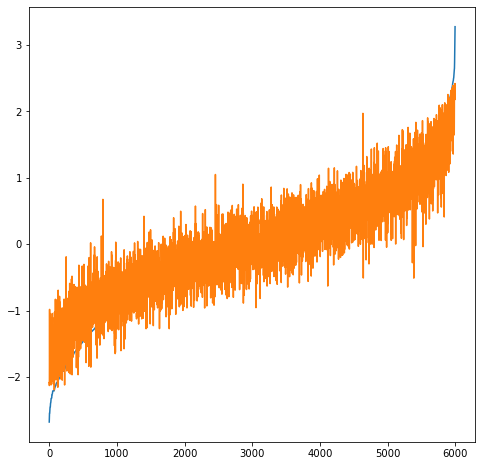

test


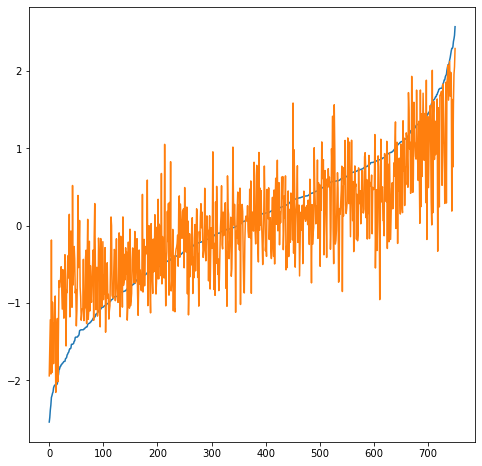

train
mape: 2.287872922131376
mae: 29807781.284692213
rmse: 81914385.41085365
adj_r2: 0.7459130224075012
test
mape: 6.080221738817653
mae: 42713994.92697391
rmse: 96396051.73451293
adj_r2: 0.38799130460274434
train log


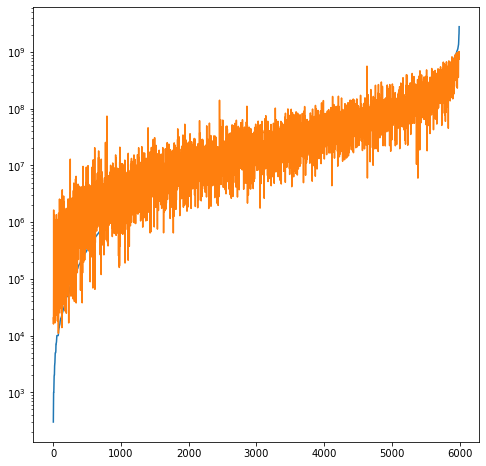

test log


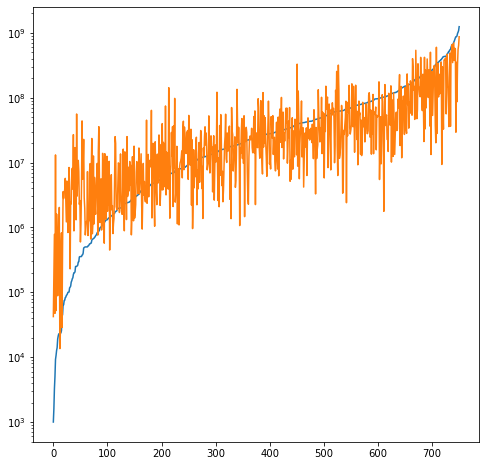

train


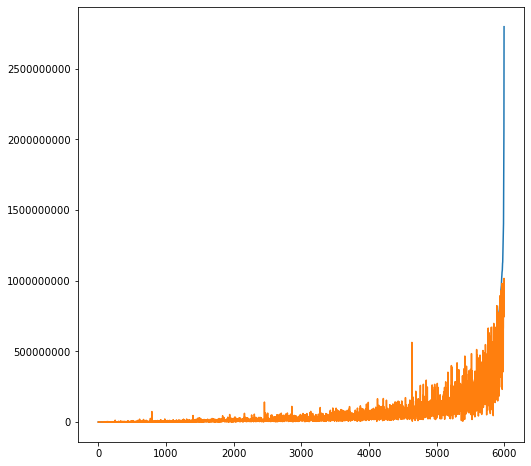

test


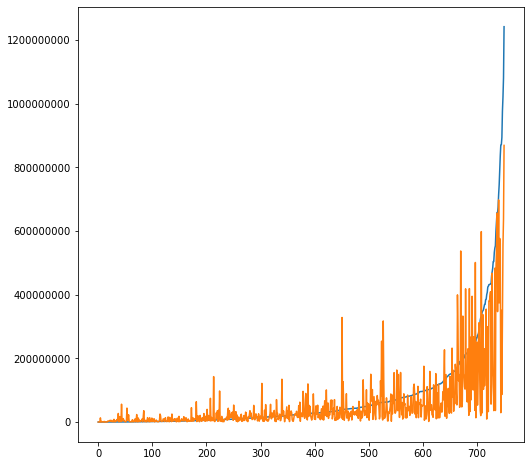

In [23]:
import lightgbm as lgb
mod_lgb = lgb.LGBMRegressor(
#     boosting='dart',
    num_iterations=50000,
    objective='regression',
    bagging_fraction=0.961,
    bagging_freq=6, 
    colsample_bytree=0.73,
    feature_fraction=0.59,
    learning_rate=0.001, 
    max_bin=104,
    max_depth=17,
    min_child_samples=191,
    min_child_weight=10.0,
    min_data_in_leaf=50, 
    min_sum_hessian_in_leaf=50,
#     n_estimators=2500,
    num_leaves=129,
    reg_alpha=3.115,
    reg_lambda=26,
    subsample=0.39,
    feature_fraction_seed=9,
    bagging_seed=9,
    tree_learner='data',
)
mod_lgb.fit(
    data['X_train'].values, 
    data['y_train'],
    verbose=2,
    eval_metric='rmse',
    eval_set=(data['X_test'], data['y_test']),
    early_stopping_rounds=100,
)
output_metrics(mod_lgb, data, process, with_val=True)

train
mape: 3.0300475033401932
mae: 0.3315772130065427
rmse: 0.4293112097582045
adj_r2: 0.8085023349270889
test
mape: 2.2509123980107684
mae: 0.44862996096075797
rmse: 0.5871574007719151
adj_r2: 0.46040185774431
train


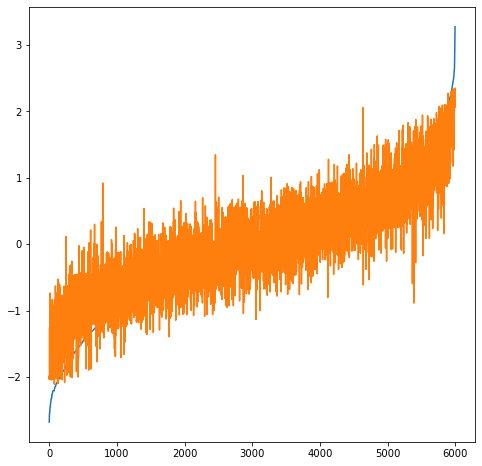

test


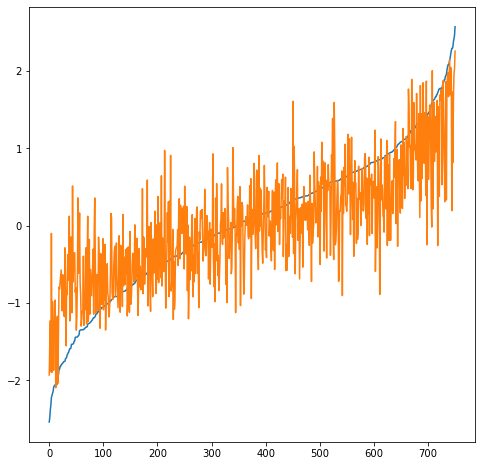

train
mape: 3.368517300565853
mae: 34216591.74213368
rmse: 90117267.09223112
adj_r2: 0.6924766631056505
test
mape: 6.5145567619237115
mae: 42780984.17663729
rmse: 95764418.88491066
adj_r2: 0.39598537305220516
train log


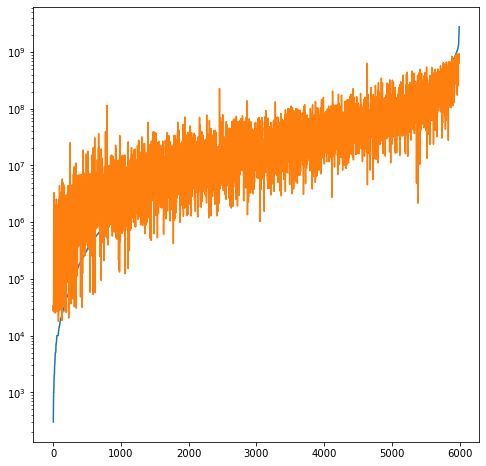

test log


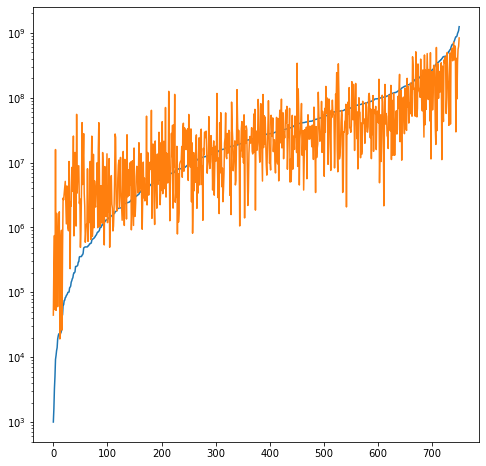

train


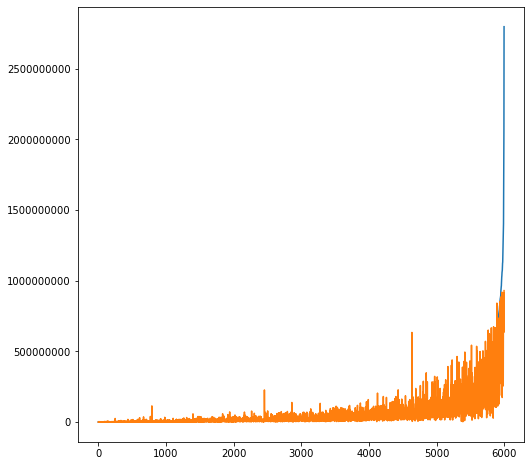

test


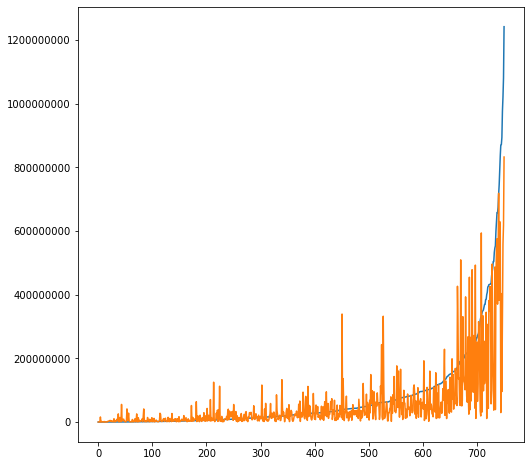

In [27]:
import lightgbm as lgb
mod_lgb = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=34,
    learning_rate=0.001, 
    n_estimators=7500,
    max_bin=192,
    max_depth=0,
    min_child_samples=160,
    min_child_weight=0.001,
    bagging_fraction=0.98,
    bagging_freq=15, 
    feature_fraction=0.77,
    metric='l2',
    bagging_seed=9,
    min_data_in_leaf=1, 
    min_sum_hessian_in_leaf=50,
    colsample_bytree=0.87,
    reg_alpha=0.18,
    reg_lambda=30,
    subsample=0.39,
    tree_learner='data',
)
mod_lgb.fit(
    data['X_train'].values, 
    data['y_train'],
    verbose=0,
    eval_metric='mse',
    eval_set=[(data['X_test'], data['y_test'])],
    early_stopping_rounds=25
)
output_metrics(mod_lgb, data, process, with_val=True)

In [ ]:
param_test_etr ={
    'n_estimators': [100, 500, 750, 1000, 5000, 10000],
    'max_depth': sp_randint(1, 200),
    'max_features': sp_randint(10, 225), 
    'min_samples_leaf': sp_randint(1,50), 
    'min_samples_split': sp_randint(1,50),
    'min_weight_fraction_leaf': sp_uniform(0.0, 0.5),
    'max_leaf_nodes': sp_randint(1, 200),
    'min_impurity_decrease': sp_uniform(0.0, 5),
    'ccp_alpha': sp_uniform(0.0, 5),
}

In [ ]:
reg_etr = ExtraTreesRegressor(
    n_jobs=-1, 
    random_state=0,
    verbose=5,
)
reg_etr_gs = RandomizedSearchCV(
    n_jobs=-1, 
    estimator=reg_etr, 
    param_distributions=param_test_etr, 
    n_iter=10,
    cv=5,
    refit=True,
    random_state=314,
    verbose=10)

In [ ]:
%%time

reg_etr_gs.fit(data['X_train'], data['y_train'])

In [ ]:
print('Best score reached: {} with params: {} '.format(reg_etr_gs.best_score_, reg_etr_gs.best_params_))

In [ ]:
etr = ExtraTreesRegressor(
    n_jobs=-1, 
    ccp_alpha=0.32,
    max_depth=10,
    max_features=71, 
    max_leaf_nodes=55,
    min_impurity_decrease=0.35,
    min_samples_leaf=8, 
    min_samples_split=23,
    min_weight_fraction_leaf=0.29,
    n_estimators=5000, 
    
)
etr.fit(data['X_train'].values, data['y_train'])
output_metrics(etr, data, process, with_val=True)

In [28]:
# def model(X_train, y_train, X_test, y_test):
    
#     model = tf.keras.Sequential()
#     model.add(Dense(
#         {{choice([128, 192, 256, 512, 1024, 2048])}}, 
#         input_shape=[255],
#         kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
#         bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},  
#         kernel_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#         bias_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#         activity_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}})))
#     model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
#     if {{choice(['bn1_yes', 'bn1_no'])}} == 'bn1_yes':
#         model.add(BatchNormalization())
#     model.add(Dropout({{uniform(0, 1)}}))
#     model.add(Dense(
#         {{choice([128, 256, 512, 1024, 2048])}},
#         kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
#         bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},          
#         kernel_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#         bias_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#         activity_regularizer=l1_l2(
#             l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#             l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}})))
#     model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
#     if {{choice(['bn2_yes', 'bn2_no'])}} == 'bn2_yes':
#         model.add(BatchNormalization())
#     model.add(Dropout({{uniform(0, 1)}}))
    
#     if {{choice(['two', 'three'])}} == 'three':
#         model.add(Dense(
#             {{choice([128, 256, 512, 1024, 2048])}},
#             kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
#             bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},  
#             kernel_regularizer=l1_l2(
#                 l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#                 l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#             bias_regularizer=l1_l2(
#                 l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#                 l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}),
#             activity_regularizer=l1_l2(
#                 l1={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}}, 
#                 l2={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001, 0])}})))
#         if {{choice(['bn3_yes', 'bn3_no'])}} == 'bn3_yes':
#             model.add(BatchNormalization())
#         model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
#         model.add(Dropout({{uniform(0, 1)}}))
        
#     model.add(Dense(1))
    
#     adamax = keras.optimizers.Adamax(
#     learning_rate={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001])}},
#     beta_1={{choice([0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999])}},
#     beta_2={{choice([0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999])}})
        
#     model.compile(loss='mse', 
#                   metrics=['mae'],
#                   optimizer=adamax)

#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#     model.fit(X_train, y_train,
#               batch_size={{choice([16, 32, 64, 128, 256, 512])}},
#               epochs=500,
#               verbose=2,
#               validation_data=(X_test, y_test),
# #               validation_split=0.15,
#               callbacks=[es])

#     mse, mae = model.evaluate(X_test, y_test, verbose=1)
#     print('Test mse:', mse)
#     return {'loss': mse, 'status': STATUS_OK, 'model': model}

def model(X_train, y_train, X_test, y_test):
    
    model = tf.keras.Sequential()
    model.add(Dense(
        256,
        input_shape=(225,),
        kernel_initializer='glorot_normal',
        activation='sigmoid', 
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)))        
    model.add(Dropout(0.005))
    model.add(Dense(
        256,
        activation='sigmoid',
        kernel_initializer='glorot_normal', 
        kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(0.5))
        
    model.add(Dense(
        1,
        kernel_initializer='glorot_normal',
        activation='linear'
    ))
    
    adamax = keras.optimizers.Adamax(
        learning_rate={{choice([0.1, 0.01, 0.001, 0.0001, 0.00001])}},
        beta_1={{choice([0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999])}},
        beta_2={{choice([0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999])}})
        
    model.compile(loss='mse', 
                  metrics=['mae'],
                  optimizer=adamax)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model.fit(X_train, y_train,
              batch_size=256,
              epochs=500,
              verbose=2,
              shuffle=True,
              validation_data=(X_test, y_test),
#               validation_split=0.15,
              callbacks=[es])

    mse, mae = model.evaluate(X_test, y_test, verbose=1)
    print('Test mse:', mse)
    return {'loss': mse, 'status': STATUS_OK, 'model': model}

In [29]:
best_run = None
best_model = None
space = None
best_run, best_model, space = optim.minimize(model=model,
                                      data=get_data,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=Trials(),
                                      notebook_name='keras',
                                      eval_space=True,
                                      return_space=True)

>>> Imports:
#coding=utf-8

try:
    import time
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from statistics import mean
except:
    pass

try:
    from sklearn import metrics
except:
    pass

try:
    from sklearn.utils import shuffle
except:
    pass

try:
    from sklearn.impute import SimpleImputer
except:
    pass

try:
    from sklearn.neural_network import MLPRegressor
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    from sklearn.preprocessing import PowerTransformer
except:
    pass

try:
    from sklearn.preprocessing import RobustScaler
except:
    pass

try:
    from sklearn.experimental import enable_iterative_imputer
except:
    pass

try:
    from sklearn.impute import IterativeImputer
except:
    pass

try:
    from sklearn.impute import 

                                                     
21/24 [=========================>....]                
 - ETA: 0s - loss: 39698806341632.0000 - mae: 925.5941
                                                     
24/24 [==============================]                
 - 0s 10ms/step - loss: 39698802147328.0000 - mae: 924.3350

Test mse:                                             
39698802147328.0                                      
  3%|▎         | 1/30 [00:06<03:15,  6.76s/trial, best loss: 39698802147328.0]


KeyboardInterrupt: 

In [43]:
best_run

In [ ]:
output_metrics(best_model, data, process)

In [20]:
adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.95,beta_2=0.999)

def build_model():
  model = tf.keras.Sequential([
    Dense(
        256, 
        activation='sigmoid', 
        input_shape=[len(data['X_train'].keys())],
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
    ),
    Dropout(0.005),
    Dense(
        256, 
        activation='sigmoid',
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
    ),
    Dropout(0.5),  
    Dense(
        1,
        kernel_initializer='glorot_normal',
        activation='linear'
    )
  ])

  model.compile(loss='mse',
                optimizer=adamax,
                metrics=['mae', 'mse'])
  return model

model3 = build_model()
# model3.summary()

es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=20)

history = model3.fit(
    data['X_train'], data['y_train'],
    epochs=1000, 
    validation_data=(data['X_test'], data['y_test']),
    verbose=0,
    batch_size=256,
    shuffle=True,
    callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])


Epoch: 0, loss:1.6076,  mae:0.8021,  mse:1.0266,  val_loss:1.0510,  val_mae:0.5554,  val_mse:0.4778,  
....................................................................................................
Epoch: 100, loss:0.4058,  mae:0.4472,  mse:0.3357,  val_loss:0.3924,  val_mae:0.4315,  val_mse:0.3226,  
....................................................................................................
Epoch: 200, loss:0.3858,  mae:0.4435,  mse:0.3242,  val_loss:0.3847,  val_mae:0.4303,  val_mse:0.3232,  
............................Epoch 00228: early stopping


train
mape: 14.947225475982815
mae: 0.4203310051661169
rmse: 0.5468697446282063
adj_r2: 0.6892673994599183
test
mape: 2.474222048232755
mae: 0.4511593268738367
rmse: 0.586504242286836
adj_r2: 0.4616016964058023
train


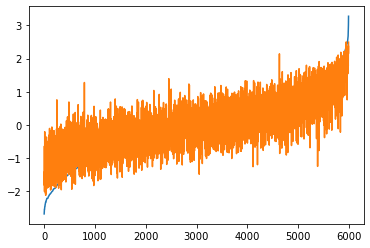

test


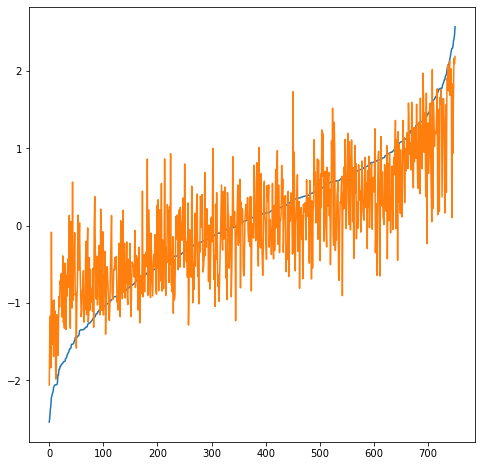

train
mape: 8.350636796705897
mae: 39271021.73661644
rmse: 96886649.55418818
adj_r2: 0.6445406613700593
test
mape: 6.832474087786092
mae: 41857489.465768166
rmse: 92704340.97075476
adj_r2: 0.4339702704554331
train log


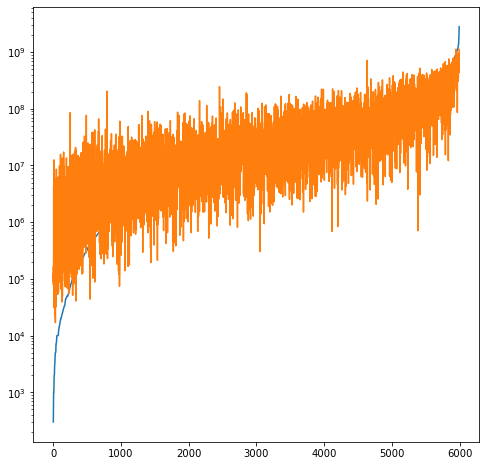

test log


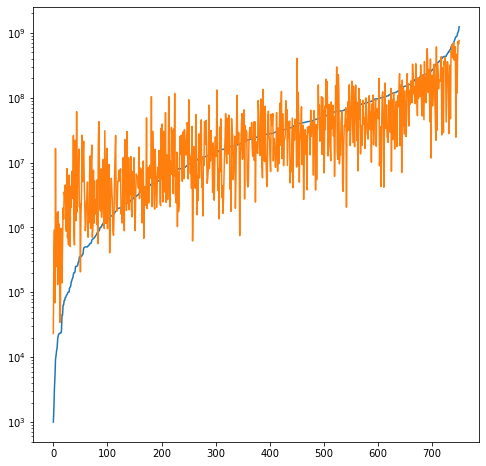

train


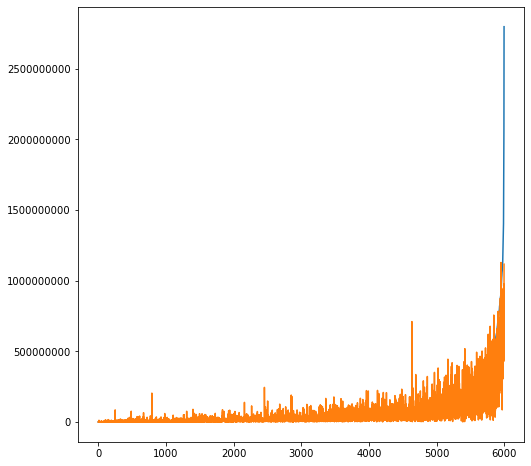

test


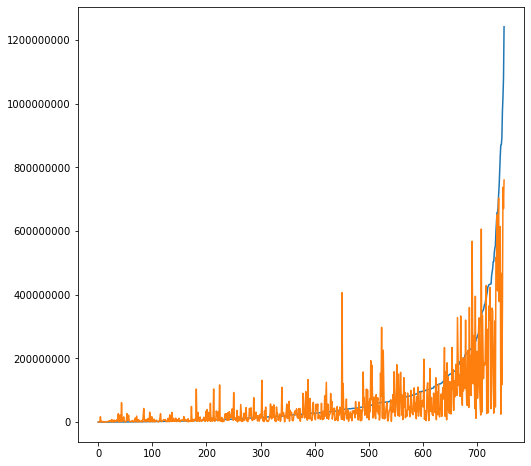

In [21]:
output_metrics(model3, data, process, with_val=True)

train
mape: 2.586535251021115
mae: 0.4285075668975065
rmse: 0.5533423399440596
adj_r2: 0.6818725247274297
test
mape: 1.8696460180115901
mae: 0.441701974716942
rmse: 0.5803624943829464
adj_r2: 0.5046193003719412
train


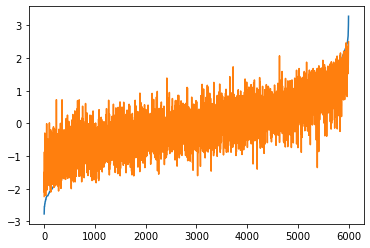

test


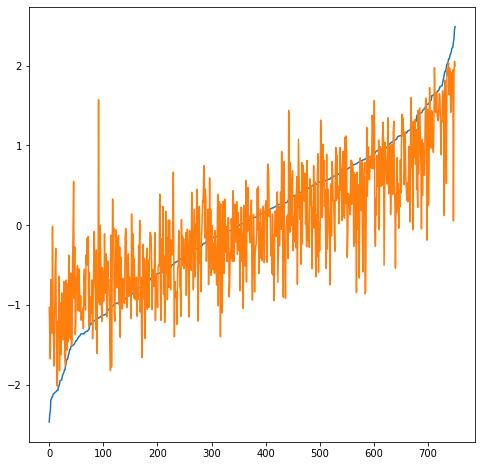

train
mape: 7.385036539149764
mae: 41531519.82335895
rmse: 103234347.11256276
adj_r2: 0.607230438072726
test
mape: 7.7197160924513675
mae: 39784996.79659375
rmse: 83923678.71610811
adj_r2: 0.49771967883058166
train log


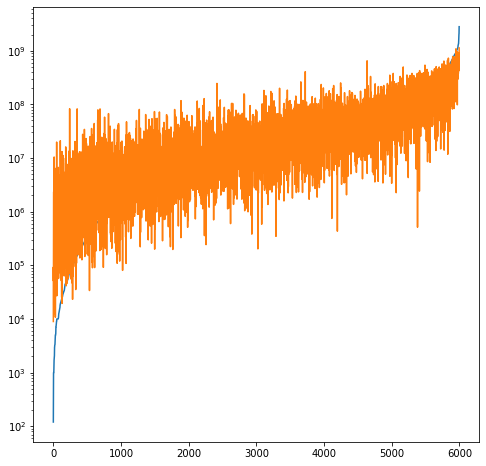

test log


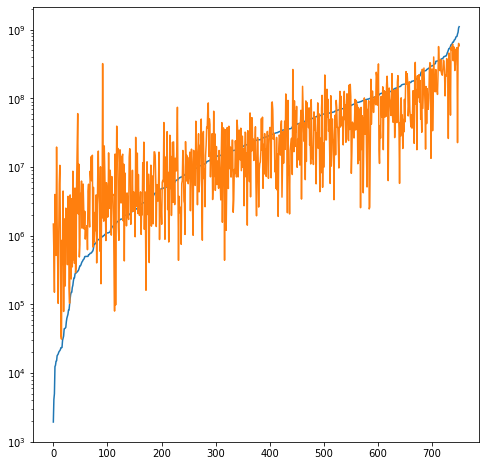

train


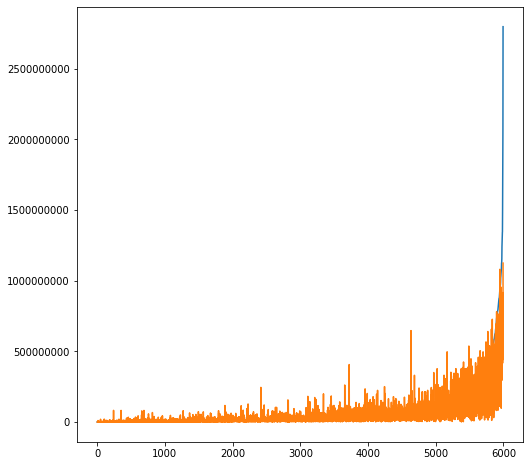

test


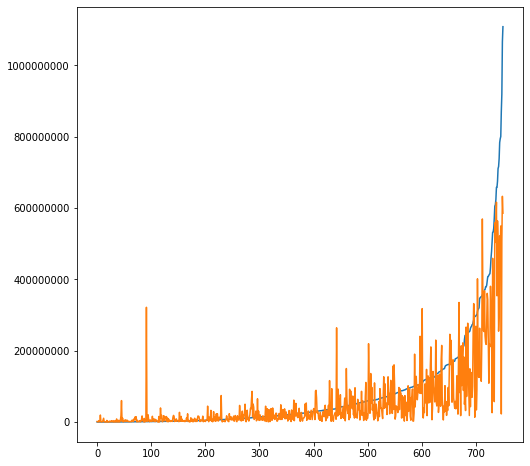

In [23]:
output_metrics(model3, data, process, with_val=True)

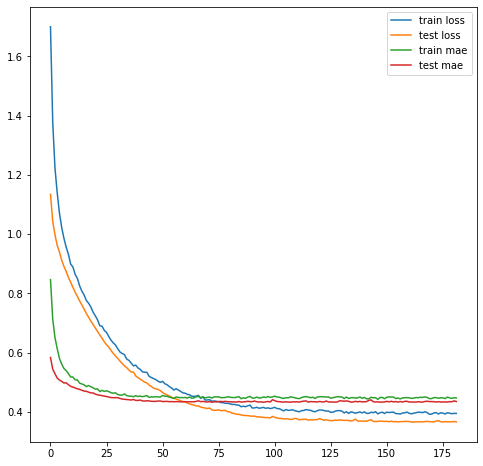

In [24]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test loss')
pyplot.plot(history.history['mae'], label='train mae')
pyplot.plot(history.history['val_mae'], label='test mae')
pyplot.legend()
pyplot.show()

In [ ]:
# relu wo initialization

# mape: 6.6013761902604395
# mae: 47785029.21390841
# rmse: 117085745.28254725
# adj_r2: 0.2683608578800275

In [ ]:
# sigmoid

# mape: 6.921294519771364
# mae: 46309187.6036963
# rmse: 106573312.92760979
# adj_r2: 0.39384203627853387

In [ ]:
# sigmoid initialization glorot

# mape: 5.891309178898037
# mae: 45178191.806934245
# rmse: 105538830.70659108
# adj_r2: 0.40555259042845115

In [ ]:
# relu initialization he-normal

# mape: 11.22876428439224
# mae: 49985922.89351641
# rmse: 124054429.88760668
# adj_r2: 0.1786780362328163

In [ ]:
# {'Dense': 1024,
#  'Dense_1': 256,
#  'Dense_2': 1024,
#  'Dropout': 0.15106219282775246,
#  'Dropout_1': 0.6763508226311498,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.30987873188582754,
#  'batch_size': 256,
#  'choiceval': 'adam',
#  'lr': 0.001,
#  'lr_1': 0.01,
#  'lr_2': 0.1}

# mape: 14.735849474528678
# mae: 42425257.59364493
# rmse: 93314406.47801651
# adj_r2: 0.5986823964694081

In [ ]:
# {'Dense': 256,
#  'Dense_1': 1024,
#  'Dense_2': 1024,
#  'Dropout': 0.2974750265433348,
#  'Dropout_1': 0.39966419778642664,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.526026582745637,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'sigmoid',
#  'batch_size': 128,
#  'epochs': 75,
#  'kernel_initializer': <tensorflow.python.ops.init_ops_v2.VarianceScaling at 0x7f8b393ae710>,
#  'kernel_initializer_1': <tensorflow.python.ops.init_ops_v2.GlorotUniform at 0x7f8b393f3610>,
#  'kernel_initializer_2': <tensorflow.python.ops.init_ops_v2.VarianceScaling at 0x7f8b2aec9750>,
#  'optimizer': 'adam'}

# mape: 11.930947077248565
# mae: 41936947.39355901
# rmse: 94227681.26787286
# adj_r2: 0.5117092256416581

In [ ]:
# {'Dense': 256,
#  'Dense_1': 256,
#  'Dense_2': 1024,
#  'Dropout': 0.12206225819915595,
#  'Dropout_1': 0.197064731659927,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.00029842311592569865,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'relu',
#  'batch_size': 128,
#  'epochs': 25,
#  'kernel_initializer': 'glorot_normal',
#  'kernel_initializer_1': 'glorot_normal',
#  'kernel_initializer_2': 'glorot_uniform',
#  'optimizer': 'adam'}

# mape: 6.224157960480135
# mae: 43643280.72317956
# rmse: 99891850.23558912
# adj_r2: 0.5618906445214958

In [ ]:
# {'Dense': 512,
#  'Dense_1': 1024,
#  'Dense_2': 1024,
#  'Dropout': 0.003154114487844459,
#  'Dropout_1': 0.49453988643233404,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.6057457357612506,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'sigmoid',
#  'batch_size': 512,
#  'epochs': 100,
#  'kernel_initializer': 'glorot_normal',
#  'kernel_initializer_1': 'he_uniform',
#  'kernel_initializer_2': 'glorot_normal',
#  'optimizer': 'adam'}


# mape: 5.984611554637821
# mae: 43830607.21558445
# rmse: 99151995.47327316
# adj_r2: 0.5683563756398305

In [ ]:
# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         512, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         1024, 
#         activation='sigmoid',
#         kernel_initializer='he_uniform',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#         activity_regularizer=l1_l2(l1=0, l2=0.00001)
#     ),
#     Dropout(0.7), 
#     Dense(1)
#   ])

#   model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mae', 'mean_squared_error'])
#   return model

# model3 = build_model()
# model3.summary()

# mape: 8.161095980091112
# mae: 35879531.109611064
# rmse: 87476559.6580578
# adj_r2: 0.5608763424966564

In [ ]:
# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         256, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         256, 
#         activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#     ),
#     Dropout(0.5),  
#     Dense(1)
#   ])

#   model.compile(loss='mae',
#                 optimizer='adam',
#                 metrics=['mae', 'mean_squared_error'])
#   return model

# model3 = build_model()
# # model3.summary()

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min', 
#     verbose=1, 
#     patience=50)

# history = model3.fit(
#     data['X_train'], data['y_train'],
#     epochs=10000, 
#     validation_data=(data['X_test'], data['y_test']),
#     verbose=1,
#     batch_size=256,
#     shuffle=True,
# #     callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])


# mape: 5.821131932635737
# mae: 42307258.2010261
# rmse: 95281127.2382761
# adj_r2: 0.4884981254695354

In [ ]:
# skew x -> skew y

# adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.95,beta_2=0.999)

# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         256, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         256, 
#         activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#     ),
#     Dropout(0.5),  
#     Dense(
#         1,
#         kernel_initializer='glorot_normal',
#         activation='linear'
#     )
#   ])

#   model.compile(loss='mse',
#                 optimizer=adamax,
#                 metrics=['mae', 'mse'])
#   return model

# model3 = build_model()
# # model3.summary()

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min', 
#     verbose=1, 
#     patience=20)

# history = model3.fit(
#     data['X_train'], data['y_train'],
#     epochs=1000, 
#     validation_data=(data['X_test'], data['y_test']),
#     verbose=0,
#     batch_size=256,
#     shuffle=True,
# #     callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])

# mape: 6.094501890528896
# mae: 40504269.625439286
# rmse: 87054173.39806816
# adj_r2: 0.5730149701057303

In [ ]:
# # skew x -> skew y

# import lightgbm as lgb
# mod_lgb = lgb.LGBMRegressor(
#     objective='regression',
#     num_leaves=34,
#     learning_rate=0.001, 
#     n_estimators=7500,
#     max_bin=192,
#     max_depth=0,
#     min_child_samples=160,
#     min_child_weight=0.001,
#     bagging_fraction=0.98,
#     bagging_freq=15, 
#     feature_fraction=0.77,
#     feature_fraction_seed=9,
#     bagging_seed=9,
#     min_data_in_leaf=1, 
#     min_sum_hessian_in_leaf=50,
#     colsample_bytree=0.87,
#     reg_alpha=0.18,
#     reg_lambda=30,
#     subsample=0.39,
#     tree_learner='data',
# )
# mod_lgb.fit(
#     data['X_train'].values, 
#     data['y_train'],
#     verbose=0,
#     eval_metric='mse',
#     eval_set=[(data['X_test'], data['y_test'])],
#     early_stopping_rounds=25
# )
# output_metrics(mod_lgb, data, process, with_val=True)

# mape: 8.358551244895033
# mae: 40639301.811736666
# rmse: 83874926.05518548
# adj_r2: 0.49830307531562434